<a href="https://colab.research.google.com/github/pietroventurini/predict-future-sales/blob/main/Predict_Future_Sales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition: Predict Future Sales

TODO
- trattare diversamente items nel test set di cui si ha informazione nel train set da quelli che non compaiono nel train set.

In the [**predict future sales**](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) competition we are working with a time-series dataset consisting of daily sales data. The goal is to predict total sales for every product and store in the next month.

We are going to approach the problem in this way:
1. **Exploratory data analysis:** take a look at the dataset and perform data cleaning.
2. **Feature engineering:** understand which useful information can be extracted from the features.
3. **Modelling:** choose a suitable model for the problem.
4. **Training:** train the model on the training set
5. **Tweaking the model:** tweak the model parameters in order to improve the performances.
6. **Model evaluation:** try to predict future sales and evaluate the performances of the model.

# Exploratory Data Analysis



Let's start by exploring the content of our dataset. According to the competition description, the training data is provided in 4 different .csv files:

- `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.
- `items.csv` - supplemental information about the items/products.
- `item_categories.csv`  - supplemental information about the items categories.
- `shops.csv`- supplemental information about the shops.

Sales and shops are represented by the following fields:

- `ID` - an Id that represents a (Shop, Item) tuple within the test set
- `shop_id` - unique identifier of a shop
- `item_id` - unique identifier of a product
- `item_category_id` - unique identifier of item category
- `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure
- `item_price` - current price of an item
- `date` - date in format dd/mm/yyyy
- `date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- `item_name` - name of item
- `shop_name` - name of shop
- `item_category_name` - name of item category

The content of the datasets is in russian, so we may think of translating it into english because many interesting features can be extracted from the names of the products, shops and categories, for instance:
- Books - Audio Books
- Books - Computer books
- Books - …

From those names we could build a feature that contains only the top level category. The translation can be done manually using some python libraries (e.g. googletrans), but other competitors have already taken the trouble to translate it for us. Translated datasets can be recognized by the `_en` suffix. However, translation can break the structure of some names (e.g. russian shop names comes in the format `city | type | name`, so by translating them in english we risk to break that structure) and complicate our life when extracting features from them.

In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Loading data

In [347]:
train = pd.read_csv('./datasets/sales_train.csv')
items = pd.read_csv('./datasets/items.csv')
categories = pd.read_csv('./datasets/item_categories.csv')
shops = pd.read_csv('./datasets/shops.csv')
test = pd.read_csv('./datasets/test.csv')

train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [348]:
# convert date from string to datetime
train['date'] = pd.to_datetime(train['date'])

print("\n-----------Information-----------")
print(train.info())
print("\n----------Null values-----------")
print(train.isnull().sum())
print("\n----------Shape of Data----------")
print(train.shape)


-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None

----------Null values-----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

----------Shape of Data----------
(2935849, 6)


### Downcasting

As we can see from the information block, the training set is 134.4+ MB in size, so, in order to reduce the memory occupation, we can downcast the dataframe from _int64_ and _float64_ to _int16_ and _float32_.

In [349]:
def downcast(df): 
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    float32       
dtypes: datetime64[ns](1), float32(2), int16(3)
memory usage: 61.6 MB


We have reduced the size of the training set from 134.4 MB down to 61.6+ MB.

## Data cleaning

In [350]:
# remove duplicated rows
train = train.drop_duplicates()

# view information about prices and sold quantities
train[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935843e+06,2.935843e+06
mean,8.906237e+02,1.242641e+00
std,1.726442e+03,2.612216e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


The first thing that catches the eye is the fact that the minimum price and the minimum sold quantity are negative, respectively, the minimum price is -1 and the minimum sold quantity is -22. 

### Negative prices

In [351]:
# items with price <= 0
neg_items = train.loc[train['item_price'] <= 0]
neg_items

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [352]:
# get details of the item with price < 0
neg_item = neg_items.iloc[0]
items.loc[items['item_id'] == neg_item['item_id']]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


Fortunately, there is only one item with a negative price. We could replace it with the median of the prices, but let's try to be more precise. The item in question is a PS3 game. Typically, game prices decreases over time from their release date, and tend to be the same among different sellers. Therefore, let's see if other shops sold the same item in that date (extending the search to the same week or month, if necessary), and use that price as a proxy for our missing value. Otherwise, we could average the price for that item from the same shop in the next few days.

In [353]:
train[(train['item_id'] == neg_item['item_id']) & (train['date'] == neg_item['date'])]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [354]:
# set the product price to that value
train.loc[train.item_price <= 0, 'item_price'] = 1249.0

### Negative quantities sold

Let's now deal with negative quantities sold. By looking at some of the discussions on the competition page, I've seen that many people considered negative values for `item_cnt_day` as returned items. Let's stick to that interpretation and set them equal to zero.

In [355]:
train.loc[train.item_cnt_day < 0] = 0

### Outliers

Let's take a look at the distributions of prices and quantities.

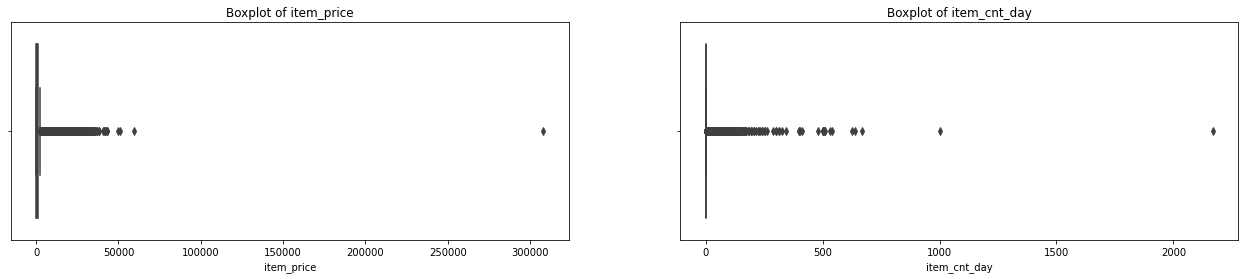

In [356]:
fig, axs = plt.subplots(1, 2, figsize=(22,4))
sns.boxplot(x='item_price', data=train, ax=axs[0])
sns.boxplot(x='item_cnt_day', data=train, ax=axs[1])
axs[0].set_title('Boxplot of item_price')
axs[1].set_title('Boxplot of item_cnt_day')
plt.show()

First of all, there is an item with a very large price that we should inspect. Similarly there are few items with a large number of units sold in a single day.

In [357]:
# most expensive item
train.loc[train.item_price.idxmax()]

date              2013-12-13 00:00:00
date_block_num                     11
shop_id                            12
item_id                          6066
item_price                     307980
item_cnt_day                        1
Name: 1163158, dtype: object

In [358]:
# most sold item in a day
train.loc[train.item_cnt_day.idxmax()]

date              2015-10-28 00:00:00
date_block_num                     33
shop_id                            12
item_id                         11373
item_price                   0.908714
item_cnt_day                     2169
Name: 2909818, dtype: object

In [359]:
fig = px.scatter(train.loc[train.item_id == 11373], x='date', y='item_cnt_day', title="Quantities of item #11373 (Boxberry delivery) sold every day")
fig.show()

I decided to remove those outliers since
1. The item with cost 6066 (which is a product called _"Radmin 3"_) has been sold exactly one time on that day only.
2. The item sold 2169 times in a single day (that i suspect to be a service rather than a product, because of its name _"Delivery to the delivery point (Boxberry)"_) is sold in much smaller quantities in every other date.

### Duplicated shops

As other participants pointed out, some shops have the same name. The shops list is short enough to be inspected manually so we can find them. If it were longer, we could have applied some fuzzy string matching algorithm on the shops names (e.g. we could have measured similarity between names using the Levenshtein distance) in order to detect similar names. Since there was no further information about the shops other than their name, and since in the test set they appear with only one of the two IDs, I decided to merge together those with the same name, using the IDs in the test set.
- 0 ⇒ 57
- 1 ⇒ 58
- 11 ⇒ 10
- 40 ⇒ 39

In [360]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1500]

In [361]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 11, 'shop_id'] = 10
train.loc[train.shop_id == 40, 'shop_id'] = 39

# keep only shops that are present either in the train set or in the test set
shops = shops.loc[shops.shop_id.isin(train.shop_id) | shops.shop_id.isin(test.shop_id)]

In [362]:
## Rimuovere o spostare

#sales_by_item = train.pivot_table(values='item_cnt_day', index=['item_id'], columns=['date_block_num'], aggfunc=np.sum, fill_value=0).reset_index()
#sales_by_item.columns = sales_by_item.columns.map(str)
#sales_by_item = sales_by_item.rename_axis(None, axis=1)
#sales_by_item

# Feature engineering

In this section we will try to create features that may help the model to make more accurate predictions about future sales. Remember that we are requested to predict sales for product-store pairs.

## Shops

Let's start by dealing with shops. Each shops is simply described by `shop_name`. By looking at their names, it looks like that every name has the structure `Shop City | Shop Type | Shop Name` (this was pointed out by other competitors who understand russian language). Thanks to this, we can extract those information into separate features.

In [363]:
# remove non alphanumeric characters and numbers
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()

# get city names (first word) 
shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

# get shop types
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x 
                         else 'трц' if 'трц' in x 
                         else 'трк' if 'трк' in x 
                         else 'тц' if 'тц' in x 
                         else 'тк' if 'тк' in x 
                         else np.nan)

In [364]:
# add first month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].min()).rename(columns={'date_block_num':'first_month'})

# add last month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].max()).rename(columns={'date_block_num':'last_month'})

For every shop in the test set we have data up to the last month in the training set (`date_block_num = 33`). There are some shops that do not pop up in the test set, anyway, they can still be useful to predict certain product sales for other shops.

In [365]:
print("Shops that are not in the test set: ", shops.loc[~shops.shop_id.isin(test.shop_id), 'shop_id'].to_list())
# uncomment next line to see details about those shops
# shops[~shops.shop_id.isin(test.shop_id)]

Shops that are not in the test set:  [8, 9, 13, 17, 20, 23, 27, 29, 30, 32, 33, 43, 51, 54]


## Item categories


Categories are described by a name which can have either the form `type - subtype` (e.g. `Книги - Путеводители` which means `books - travel guides`) or a single name (e.g. `Доставка товара` which means `delivery of goods`). Let's split composite category names into:
- section
- main category name
- main sub-category name
- secondary sub-category name

Here we have to get our hands dirty and deal with each category in detail because not every name has that structure.

Note: I decided to translate sections into english for visualization purposes, but note that it was not necessary since later we will perform label encodings.

In [366]:
# before
categories[:10]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [367]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['section'] = categories['split'].map(lambda x: x[0].strip())
categories['name'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0])
categories = categories[['item_category_id', 'section', 'name']]

# games
categories.loc[26:31, 'sub_name'] = categories.loc[26:32, 'name']
categories.loc[26:31, 'name'] = categories.loc[26:32, 'section'].str.split(' ').map(lambda x: x[1])
categories.loc[18:31, 'section'] = 'games'

# PlayStation stuff
is_ps = categories.name.str.contains('PS')
categories.loc[is_ps, 'sec_sub_name'] = categories.loc[is_ps, 'name'].map(lambda x: x.split('PS')[1])
categories.loc[is_ps, 'sub_name'] = 'PS'

# XBOX stuff
is_xbox = categories.name.str.contains('XBOX')
categories.loc[is_xbox, 'sec_sub_name'] = categories.loc[is_xbox, 'name'].map(lambda x: x.split('XBOX')[1])
categories.loc[is_xbox, 'sub_name'] = 'XBOX'

# split name - subname
categories.loc[45, 'sec_sub_name'] = '1C'
categories.loc[43:45, 'sub_name'] = 'audiobooks'
categories.loc[55, 'sec_sub_name'] = 'локального'
categories.loc[56, 'sec_sub_name'] = 'фирменного'
categories.loc[55:56, 'sub_name'] = 'CD'
categories.loc[81:82, 'sub_name'] = categories.name.loc[81:82].map(lambda x: x[x.find('(')+1:x.find(')')])

# extract subname within brackets e.g. {name: "Live! (Цифра)"} --> {sub_name: "Live!", sec_sub_name: "Цифра"}
has_subname = categories.name.str.contains('\(.*?\)')
categories.loc[has_subname, 'sec_sub_name'] = categories.loc[has_subname, 'name'].map(lambda x: x[x.find('(')+1:x.find(')')])
categories.loc[has_subname, 'sub_name'] = categories.loc[has_subname, 'name'].str.split('(').map(lambda x: x[0])

# rename sections
categories.loc[1:7, 'section'] = 'accessories'
categories.loc[8, 'section'] = 'tickets'
categories.loc[9, 'section'] = 'delivery of goods'
categories.loc[10:17, 'section'] = 'consoles'
categories.loc[32:36, 'section'] = 'cards'
categories.loc[37:41, 'section'] = 'movies'
categories.loc[42:54, 'section'] = 'books'
categories.loc[55:60, 'section'] = 'music'
categories.loc[61:72, 'section'] = 'gifts'
categories.loc[73:78, 'section'] = 'software'
categories.loc[81:82, 'section'] = 'disks'
categories.loc[83, 'section'] = 'batteries'

In [368]:
# after
categories[:10]

,item_category_id,section,name,sub_name,sec_sub_name
0,0,PC,Гарнитуры/Наушники,NaN,NaN
1,1,accessories,PS2,PS,2
2,2,accessories,PS3,PS,3
3,3,accessories,PS4,PS,4
4,4,accessories,PSP,PS,P
5,5,accessories,PSVita,PS,Vita
6,6,accessories,XBOX 360,XBOX,360
7,7,accessories,XBOX ONE,XBOX,ONE
8,8,tickets,Билеты (Цифра),Билеты,Цифра
9,9,delivery of goods,Доставка товара,NaN,NaN


## Items